#🌸 Flower Species Classification Using Pretrained Model (Oxford Flowers Dataset)

### 📥Step 1: Unzip the file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/flower_dataset.zip'  # ← string, in quotes
extract_path = '/content/flower_dataset'  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
# Verify the files were extracted
extracted_files = os.listdir('/content/flower_dataset')
print(extracted_files)


['sample_submission.csv', 'cat_to_name.json', 'dataset', 'README.md']


In [6]:
import os

dataset_path = '/content/flower_dataset/dataset'
classes = os.listdir(dataset_path)
print(classes)


['valid', 'train', 'test']


### Step 2: Import Required Libraries
First, let's import the necessary libraries. We will be using TensorFlow and Keras for constructing the model, as well as libraries like NumPy and Matplotlib for data handling and visualization.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LeakyReLU

### 🧹Step 3: Setup Paths
Define the paths where your dataset and other required files are located.




In [8]:
base_path = '/content/flower_dataset/dataset'  # Path where your dataset is located
train_dir = os.path.join(base_path, 'train')
valid_dir = os.path.join(base_path, 'valid')
test_dir = os.path.join(base_path, 'test')

json_path = '/content/flower_dataset/cat_to_name.json'  # Path to the cat_to_name.json file


### Step 4: Load the cat_to_name Mapping
In this step, we load the cat_to_name.json file which maps the class IDs to the actual flower names.

In [9]:
with open(json_path, 'r') as f:
    cat_to_name = json.load(f)

# Optional: convert keys to int if needed
cat_to_name = {int(k): v for k, v in cat_to_name.items()}
print(cat_to_name)


{21: 'fire lily', 3: 'canterbury bells', 45: 'bolero deep blue', 1: 'pink primrose', 34: 'mexican aster', 27: 'prince of wales feathers', 7: 'moon orchid', 16: 'globe-flower', 25: 'grape hyacinth', 26: 'corn poppy', 79: 'toad lily', 39: 'siam tulip', 24: 'red ginger', 67: 'spring crocus', 35: 'alpine sea holly', 32: 'garden phlox', 10: 'globe thistle', 6: 'tiger lily', 93: 'ball moss', 33: 'love in the mist', 9: 'monkshood', 102: 'blackberry lily', 14: 'spear thistle', 19: 'balloon flower', 100: 'blanket flower', 13: 'king protea', 49: 'oxeye daisy', 15: 'yellow iris', 61: 'cautleya spicata', 31: 'carnation', 64: 'silverbush', 68: 'bearded iris', 63: 'black-eyed susan', 69: 'windflower', 62: 'japanese anemone', 20: 'giant white arum lily', 38: 'great masterwort', 4: 'sweet pea', 86: 'tree mallow', 101: 'trumpet creeper', 42: 'daffodil', 22: 'pincushion flower', 2: 'hard-leaved pocket orchid', 54: 'sunflower', 66: 'osteospermum', 70: 'tree poppy', 85: 'desert-rose', 99: 'bromelia', 87: 

### 📊Step 5: Data Preprocessing and Augmentation
Data augmentation helps in improving generalization and reducing overfitting. We apply several augmentations like rotation, zoom, horizontal flip, etc., to the training data. We only rescale the validation and test data to normalize the pixel values.



In [10]:
#Data Preprocessing and Augmentation
img_size = (224, 224)  # Resize all images to 224x224 pixels
batch_size = 32

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values to [0, 1]
    rotation_range=40,  # Random rotation from 0 to 40 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill missing pixels after transformations
)

# Data Augmentation for Validation Data (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Data Augmentation for Test Data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Since this is a multi-class classification problem
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


In [11]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


### Step 10: Transfer Learning
We'll use MobileNetV2 as the base model (you can change it to EfficientNet or others later if needed).

In [13]:
#Load Pretrained Model (Transfer Learning)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers

num_classes = train_generator.num_classes  # Number of classes in the dataset
# Load MobileNetV2 base model (without top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

#Add Custom Layers on Top
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global pooling instead of flatten
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Final model
model1 = Model(inputs=base_model.input, outputs=output)
model1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,612,134 (9.96 MB)

 Trainable params: 354,150 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
#Compile the Model
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)


In [15]:
#Train the Model
history1 = model1.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[early_stop, lr_reduction]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 114s 499ms/step - accuracy: 0.0774 - loss: 4.4245 - val_accuracy: 0.4939 - val_loss: 2.4583 - learning_rate: 5.0000e-04
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 434ms/step - accuracy: 0.3508 - loss: 2.7303 - val_accuracy: 0.6773 - val_loss: 1.4098 - learning_rate: 5.0000e-04
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 445ms/step - accuracy: 0.5084 - loss: 1.9259 - val_accuracy: 0.7482 - val_loss: 1.0408 - learning_rate: 5.0000e-04
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 88s 428ms/step - accuracy: 0.5827 - loss: 1.5535 - val_accuracy: 0.7812 - val_loss: 0.8641 - learning_rate: 5.0000e-04
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 433ms/step - accuracy: 0.6190 - loss: 1.3617 - val_accuracy: 0.8117 - val_loss: 0.7558 - learning_rate: 5.0000e-04
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 439ms/step - accuracy: 0.6629 - loss: 1.2146 - val_accuracy: 0.8252 - val_loss: 0.7009 - learning_rate: 5.0000e-04
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 88s 4

##### Fine tuning


In [16]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last N (e.g., 20)
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [17]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history_fine = model1.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stop, lr_reduction]
)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 113s 481ms/step - accuracy: 0.5206 - loss: 2.0025 - val_accuracy: 0.8741 - val_loss: 0.4245 - learning_rate: 1.0000e-05
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 88s 431ms/step - accuracy: 0.6877 - loss: 1.0913 - val_accuracy: 0.8741 - val_loss: 0.4305 - learning_rate: 1.0000e-05
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 439ms/step - accuracy: 0.7469 - loss: 0.8830 - val_accuracy: 0.8778 - val_loss: 0.4276 - learning_rate: 1.0000e-05
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 87s 426ms/step - accuracy: 0.7620 - loss: 0.8443 - val_accuracy: 0.8790 - val_loss: 0.4226 - learning_rate: 1.0000e-05
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 433ms/step - accuracy: 0.7804 - loss: 0.7157 - val_accuracy: 0.8826 - val_loss: 0.4255 - learning_rate: 1.0000e-05
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 88s 427ms/step - accuracy: 0.7954 - loss: 0.6895 - val_accuracy: 0.8814 - val_loss: 0.4189 - learning_rate: 1.0000e-05
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 87s 4

### ✅ Step 11: Evaluate the Fine-Tuned Model


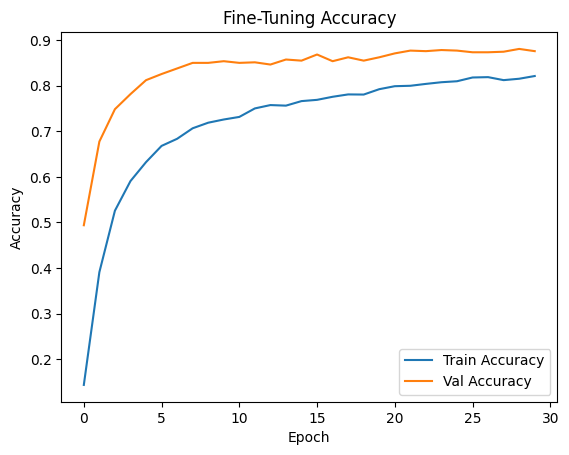

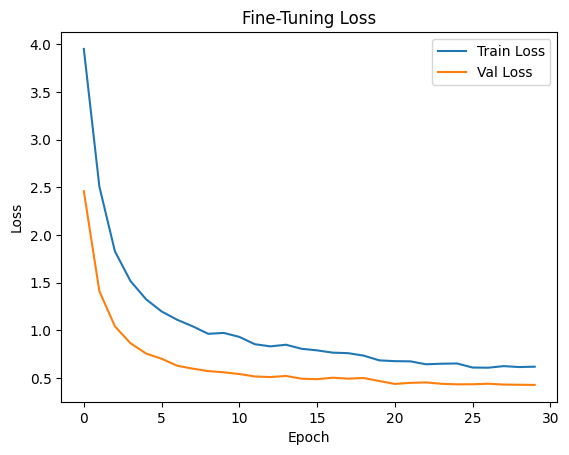

In [22]:
# Plotting the Training and Validation Accuracy/Loss
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title("Fine-Tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss Plot
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Fine-Tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### ✅Step 12: Prepare Test Predictions
In this step, we load the test data and predict the flower species using the trained model. We also prepare the final submission file (flower_submission.csv)

In [23]:
# Step 9: Prepare Test Predictions
from tensorflow.keras.preprocessing import image

def preprocess_img(path):
    img = image.load_img(path, target_size=img_size)
    img = image.img_to_array(img) / 255.0
    return img

submission_csv_path = '/content/flower_dataset/sample_submission.csv'  # Path to sample_submission.csv file

submission_df = pd.read_csv(submission_csv_path)  # Load sample_submission.csv
test_image_paths = [os.path.join(test_dir, fname) for fname in submission_df['file_name']]
test_images = np.array([preprocess_img(p) for p in test_image_paths])

# Predict the test images
preds = model1.predict(test_images)

# Convert predictions to flower ids and names
pred_indices = np.argmax(preds, axis=1)  # Get the index with the highest probability

# Map the indices back to flower ids
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
submission_df['id'] = [index_to_class[idx] for idx in pred_indices]
submission_df['flower_name'] = [cat_to_name.get(int(idx), "Unknown") for idx in pred_indices]

# Save the submission file
submission_df.to_csv('flower_submission.csv', index=False)
submission_df.head()


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step


,file_name,id,flower_name
0,image_00005.jpg,77,passion flower
1,image_00006.jpg,77,passion flower
2,image_00024.jpg,77,passion flower
3,image_00025.jpg,77,passion flower
4,image_00029.jpg,77,passion flower


### Model Saving and Reloading
Save your fine-tuned model for future inference or deployment. You can save the model in the .h5 format (for Keras) or .tf format (for TensorFlow).

In [24]:
model1.save('fine_tuned_model.h5')  # Save the model
# To load it later
from tensorflow.keras.models import load_model
loaded_model = load_model('fine_tuned_model.h5')
